In [36]:
!pip install wikipedia networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install scipy -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

In [133]:
class Pipeline:
    def __init__(self):
        self.tasks = []
        
    def task(self, depends_on=None):
        idx = 0
        if depends_on:
            idx = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(idx, f)
            return f
        return inner
    
    def run(self, input_):
        output = input_
        for task in self.tasks:
            output = task(output)
        return output

In [134]:
pipeline = Pipeline()

In [146]:
@pipeline.task()
def get(args: dict) -> nx.DiGraph:
  todo_lst = [(0, args['SEED'])] 
  todo_set = set(args['SEED']) 
  done_set = set()
  g = nx.DiGraph()
  layer, page = todo_lst[0]

  while layer < 2:
    del todo_lst[0]
    done_set.add(page)
  
    # Show progress
    print(layer, page) 
  
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print("Could not load", page)
      layer, page = todo_lst[0]
      continue
    
    for link in wiki.links:
      link = link.title()
      if link not in args['STOPS'] and not link.startswith("List Of") and np.all([word.lower() not in link.lower() for word in args['STOPS']]):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]
  print('Data capture finished')   
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

  return g

In [147]:
@pipeline.task(depends_on=get)
def remove(g):
  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  print(duplicates)

  duplicates = []
  ok_names = []
  for x, y in [(node, node.replace("-", " ")) for node in g]:
      if x != y and y in g and y not in [y for x,y in duplicates]:
          duplicates.append((x,y))
      
  print(duplicates)

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

  return g

In [148]:
@pipeline.task(depends_on=remove)
def filters(g):
  core = [node for node, drg in dict(g.degree()).items() if drg > 5 ]
  degrees = [drg for node, drg in dict(g.degree()).items() if drg > 5 ]

  subg_g = nx.subgraph(g,core)
  print(f'Nodes: {len(subg_g)} edges: {nx.number_of_edges(subg_g)}')
  return subg_g

In [149]:
def plot_graphic_degree_centrality(subg_g, pos):
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subg_g,seed=42,k=0.25)
  # color of nodes
  color = list(dict(nx.degree_centrality(subg_g)).values())

  # draw edges
  nx.draw_networkx_edges(subg_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subg_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subg_g, pos=pos,
                          font_color='white',
                          font_size = 5, 
                          ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('degree_centrality.png', transparent=True,dpi=300)
  plt.show()

In [150]:
def plot_graphic_closeness_centrality(subg_g, pos):
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subg_g,seed=42,k=0.25)
  # color of nodes
  color = list(dict(nx.closeness_centrality(subg_g)).values())

  # draw edges
  nx.draw_networkx_edges(subg_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subg_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subg_g, pos=pos,
                          font_color='white',
                          font_size = 5, 
                          ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('closeness_centrality.png', transparent=True,dpi=300)
  plt.show()

In [151]:
def plot_graphic_betweenness_centrality(subg_g, pos):
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subg_g,seed=42,k=0.25)
  # color of nodes
  color = list(dict(nx.betweenness_centrality(subg_g)).values())

  # draw edges
  nx.draw_networkx_edges(subg_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subg_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subg_g, pos=pos,
                          font_color='white',
                          font_size = 5, 
                          ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('betweenness_centrality.png', transparent=True,dpi=300)
  plt.show()

In [152]:
def plot_graphic_eigenvector_centrality(subg_g, pos):
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  pos = nx.spring_layout(subg_g,seed=42,k=0.25)
  # color of nodes
  color = list(dict(nx.eigenvector_centrality(subg_g)).values())

  # draw edges
  nx.draw_networkx_edges(subg_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subg_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)

  # draw labels
  nx.draw_networkx_labels(subg_g, pos=pos,
                          font_color='white',
                          font_size = 5, 
                          ax=ax)


  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('eigenvector_centrality.png', transparent=True,dpi=300)
  plt.show()

In [153]:
def make_pdf(subg_g):
  plt.style.use("fivethirtyeight")
  # degree sequence
  degree_sequence = sorted([d for n, d in subg_g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [154]:
@pipeline.task(depends_on=filters)
def results(subg_g):
  
  make_pdf(subg_g)
  pos = nx.spring_layout(subg_g,seed=8375,k=0.2)
  
  plot_graphic_degree_centrality(subg_g,pos)
  plot_graphic_closeness_centrality(subg_g,pos)
  plot_graphic_betweenness_centrality(subg_g,pos)
  plot_graphic_eigenvector_centrality(subg_g,pos)

  degree_centrality = pd.Series(nx.degree_centrality(subg_g))
  closeness_centrality = pd.Series(nx.closeness_centrality(subg_g))
  betweenness_centrality = pd.Series(nx.betweenness_centrality(subg_g))
  eigenvector_centrality = pd.Series(nx.eigenvector_centrality(subg_g))

  df = pd.DataFrame.from_dict({ "Degree": degree_centrality,
                               "Closeness": closeness_centrality,
                               "Betweenness": betweenness_centrality,
                              "EigenVector": eigenvector_centrality
                              })
  df.reset_index(inplace=True,drop=True)
  df.head()

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)


  plt.savefig('allGraphics.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  g2_core_9 = nx.k_shell(subg_g, 9)
  g2_core_10 = nx.k_core(subg_g, 10)

  pos = nx.spring_layout(subg_g,seed=123456789,k=0.3)

  # draw edges
  nx.draw_networkx_edges(subg_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subg_g,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(g2_core_9,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(g2_core_10,
                  pos=pos,
                  node_color="red")

  # static legend
  red_patch = mpatches.Patch(color='red', label='10-core')
  blue_patch = mpatches.Patch(color='blue', label='9-shell')
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core.png', transparent=True,dpi=600)
  plt.show()

0 Neilgaiman
1 2000X
1 2000 Ad (Comics)
1 2022 Russian Invasion Of Ukraine
1 2312 (Novel)
1 24 Views Of Mt. Fuji, By Hokusai
1 26 Monkeys, Also The Abyss
1 67Th World Science Fiction Convention
1 8In8
1 8Th Grade
1 A. E. Van Vogt
1 A Canticle For Leibowitz
1 A Case Of Conscience
1 A Clash Of Kings
1 A Dance With Dragons
1 A Dark Matter
1 A Deepness In The Sky
1 A Desolation Called Peace
1 A Fire Upon The Deep
1 A Game Of Thrones
1 A Hat Full Of Sky
1 A Head Full Of Ghosts
1 A Little Gold Book Of Ghastly Stuff
1 A Master Of Djinn
1 A Memory Called Empire
1 A Midsummer Night'S Dream
Could not load A Midsummer Night'S Dream
1 A Psalm For The Wild-Built
1 A Song For A New Day
1 A Storm Of Swords
1 A Study In Emerald
1 A Time Of Changes
1 A Walking Tour Of The Shambles
1 A Wizard'S Guide To Defensive Baking
1 Action Comics
Could not load Action Comics
1 Adam Stemple
Could not load Adam Stemple
1 Age Of Ultron
Could not load Age Of Ultron
1 Akata Warrior
Could not load Akata Warrior
1 Al Fel

/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Back Issue!
1 Bag Of Bones
1 Bard College
Could not load Bard College
1 Barrayar
1 Barry B. Longyear
1 Batman
1 Batman: Whatever Happened To The Caped Crusader?
1 Batman R.I.P.
1 Bears Discover Fire
1 Beasts Of The Southern Wild
1 Becky Chambers
1 Beggars In Spain
Could not load Beggars In Spain
1 Belsen Express
1 Benedict Cumberbatch
1 Benh Zeitlin
1 Beowulf
1 Bernard Cribbens
Could not load Bernard Cribbens
1 Bernie Mireault
1 Beyond This Horizon
1 Beyond The Dead Reef
Could not load Beyond The Dead Reef
1 Bill Griffith
1 Bill Willingham
1 Binti (Novella)
1 Black Orchid (Character)
1 Black Orchid (Comic Book)
1 Black Orchid (Comics)
1 Blackout/All Clear
1 Blood Kin
1 Blood Of The Dragon (Novella)
1 Blood Of The Lamb
1 Blueberry Girl
1 Bob Burden
1 Bob Clampett
1 Bob Haney
Could not load Bob Haney
1 Bob Schreck
1 Boy'S Life (Novel)
1 Boys For Pele
1 Bradbury Award
1 Bram Stoker Award
1 Bram Stoker Award For Best Anthology
1 Bram Stoker Award For Best Fiction Collection


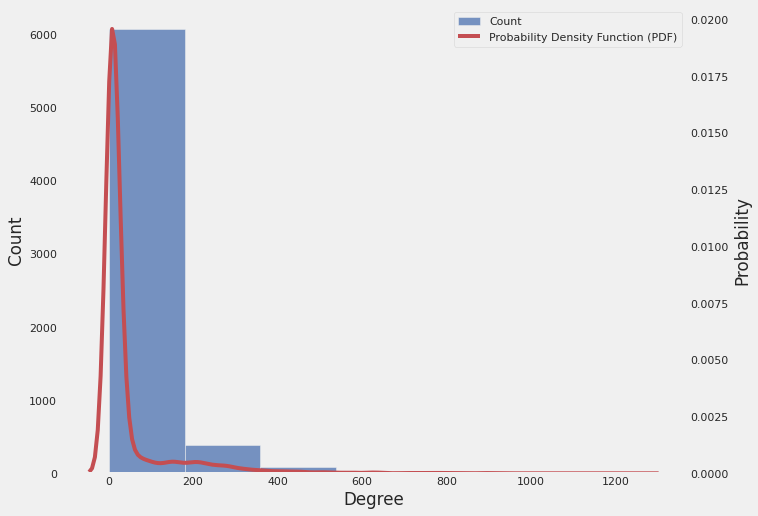

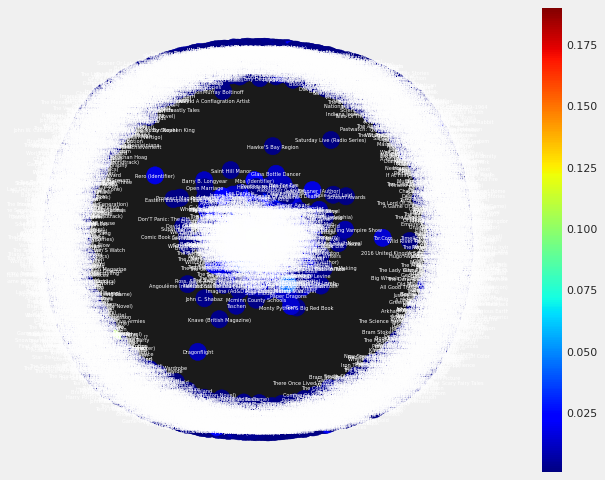

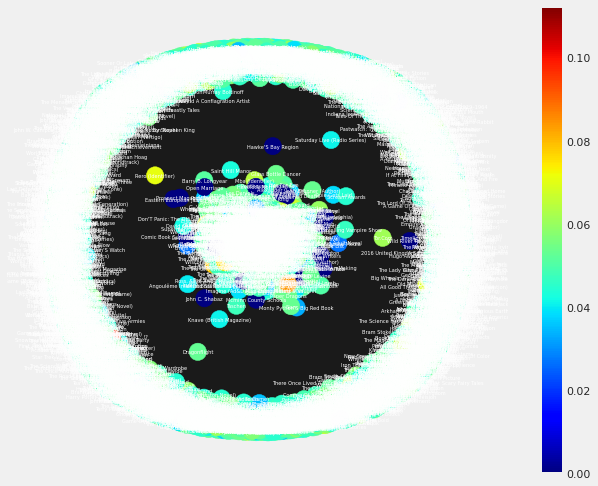

In [ ]:
stops = ("DC",
        "Amazon",
        "Movie",
        "Tv show",
        "Netflix",
        "screenwriting",
        "Marvel",
        "Story",
        "Film")
seed = "NeilGaiman".title()
args = {'SEED': seed, 'STOPS': stops }
pipeline.run(args)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=84cb924b-f123-4e15-a431-a93b26bbb4e7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>